In [32]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pyspark.pandas as ps

spark = SparkSession.builder.appName("bike").getOrCreate()
df = spark.read.option("header","true").csv("2017-fordgobike-tripdata.csv")

In [33]:
from haversine import haversine, Unit

haversine([45.7597, 4.8422], [48.8567, 2.3508])

392.2172595594006

In [34]:
def getDistance(start_lat, start_long, end_lat, end_long):
    return haversine(
        [ float(start_lat), float(start_long) ],
        [ float(end_lat), float(end_long) ],
        unit=Unit.METERS
    )

In [35]:

getDistanceUDF = udf(lambda a,b,c,d : getDistance(a,b,c,d), FloatType())

df = df.withColumn("Distance", 
        getDistanceUDF(
            df["start_station_latitude"], 
            df["start_station_longitude"], 
            df["end_station_latitude"], 
            df["end_station_longitude"]
        )
)

# Task 4

In [38]:
df = df.withColumn("age", year(current_date()) - year(col("member_birth_year")))

In [39]:
df = df.dropna(subset=["age", "distance"])

In [41]:
df_p = df.select("age", "distance")
df_pt = df_p.toPandas()

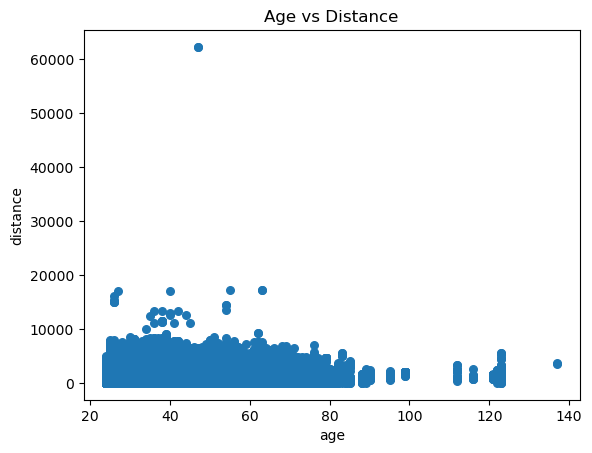

In [42]:
plt.scatter(df_pt["age"], df_pt["distance"], s=30)
plt.xlabel("age")
plt.ylabel("distance")
plt.title("Age vs Distance")
plt.show()